# Computational Methods in Economics

## Lecture 6a - Function Approximation

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2020-01-20 15:21:49.467850


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import IPython.display as display

# import sys
from importlib import reload

## This Lecture

- [Introduction](#introduction)
- [Interpolation vs. Regression](#interp)
- [Choice of Basis Functions: Polynomials](#basis)
- [Chebyshev Basis Functions](#cheb)
- [Constructing a Grid](#grid)
- [Combining Chebyshev Nodes with a Chebyshev Basis](#algo)
- [Examples: Univariate Function Approximation in Python](#funapprox1)
- [Appendix](#appendix)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

### Introduction

Suppose you are interested in a function $f$, but only have "limited information" about it. That is, you only know its function values at a finite number $m$ points $x_1, x_2,..., x_m$:  

\begin{equation}
    y_1 = f(x_1), y_2 = f(x_2), ..., y_m = f(x_m)
\end{equation}

The goal of function approximation or "curve fitting" is to use this limited information to find a function $\hat{f}$ such that

\begin{equation}
    f(x) \approx \hat{f}(x)
\end{equation}

The function $\hat{f}$ (also called *approximant*) should be computationally tractable and easy to evaluate. In this course, we will confine ourselves to functions $\hat{f}$ that are linear combinations of a set of $n + 1$ linearly independent *basis functions* $B_0, ..., B_n$:

\begin{equation}
    \hat{f}(x; \mathbf{a}) = \sum_{j = 0}^{n} a_j B_j(x)
\end{equation}

The number $n$ is referred to as the *degree of approximation*. Approximating a function then means to find appropriate values for the $n + 1$ *basis coefficients* $\mathbf{a} = a_0, ..., a_n$ given the "data" $\{y_i, x_i\}_{i = 1}^m$. 

#### Example: oligopoly

Taking first-order conditions gives the following equilibrium condition for firm $i$:

$$
   \partial \pi_1 / \partial q_1 = 0 = P(q_1 + q_2) + P'(q_1 + q_2) q_1 - C_i'(q_1) 
$$ 

This expression characterizes firm 1's decision about $q_1$ given the behaviour of firm 2, i.e. $q_2$. In other words, it defines its *reaction function*. 

### Some comments

- With respect to terminology, I use "curve fitting" and "function approximation" as synonyms: any problem where we impose a *parametric, functional relationship* $\hat{f}$ between a *dependent* variable on the left hand side and a (vector of) *explanatory* variables on the right hand side. These variables are "data" (not necessarily from the real world!) in the sense that given those, we want to find the parameters of the function that give a "good fit".

- The first distinction is whether we assume the functional relationship is *linear or nonlinear in the parameters*. Most methods used in empirical or numerical work rely on linear methods, in particular when using polynomials as basis functions. 

To simplify the exposition, I will first introduce the most important concepts for univariate functions. 

What follows below also holds for multivariate functions, in which case each of the "points" $x_1, x_2,..., x_m$ is actally a vector. For clarity, I will use bold notation in this case: $\mathbf{x}_1, \mathbf{x}_2,..., \mathbf{x}_m$, where 

\begin{equation}
    \mathbf{x}_i = (x_{1i}, x_{2i}, ..., x_{ki}).
\end{equation}

Then, we approximate a function $f(\mathbf{x})$ by:

\begin{equation}
    f(\mathbf{x}) \approx \hat{f}(\mathbf{x})
\end{equation}

using again information on the function values at a finite number of points:

\begin{equation}
    y_i = f(\mathbf{x}_i),\ i = 1,..., m.
\end{equation}



#### Example: Linear LS regression (OLS)

An application of curve fitting (usually in a multivariate setting) that you all know is linear regression.
Let $y$ denote a dependent variable and $\mathbf{x} = (x_1, ... , x_k)$ a vector of $k$ regressors. Hence, $(y_i, \mathbf{x}_i) = (y_i, x_{1i}, ..., x_{ki})$ corresponds to observation $i$. 

Then, for

\begin{equation}
    B_j(\mathbf{x}) = x_j,\ j = 1,..., k,
\end{equation}

and adding an error term, the problem above becomes

\begin{equation}
    y_i = a_0 + \sum_{j = 1}^k a_j B_j(\mathbf{x}_i) + \epsilon_i = a_0 + a_1 x_{1i} + ... + a_k x_{ki} + \epsilon_i,\ i = 1,..., m
\end{equation}

This is the simplest case of the well-known linear regression model. In this case with $k$ regressors, we need to find $k+1$ coefficients. See below for details on how to implement a regression algorithm. Note that this model can be easily extended to specifications which are nonlinear in the regressors (e.g. $x_{1i}^2$ or $x_{1i} x_{2i}$), but still linear *in the parameters*.






#### Preview

Broadly speaking, approximating a function requires the modeller to make three decisions:
1. **choose number and spacing of grid points**; for example, equally spaced points, Chebyshev nodes 
2. **choose basis functions**; for example, monomials, orthogonal polynomials, splines 
3. **choose whether to find the basis coefficients through interpolation or regression (least squares)** 



For ease of exposition, we will go through this list in reverse order, starting with the third point.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'interp'></a>

### Interpolation vs. Regression

#### Interpolation

A function $\hat{f}(x)$ *interpolates* to the data $\{x_i, y_i\}_{i = 1}^{m}$ if

\begin{equation}
    \hat{f}(x_i) = y_i = f(x_i),\ \ i = 1, ..., m
\end{equation}

where $x_1, x_2, ... , x_m$ are called *interpolation nodes* or *interpolation grid*. 

In other words, the functions $f$ and $\hat{f}$ have the same function values at the $m$ data points. Note that this results in a system of $m$ equations, the *interpolating/interpolation conditions*. With

\begin{equation}
    \hat{f}(x; \mathbf{a}) = \sum_{j = 0}^{n} a_j B_j(x), 
\end{equation}
the conditions read
\begin{align}
    y_1 &\overset{!}{=} \sum_{j = 0}^{n} a_j B_j(x_1) \\
    \vdots \\
\end{align}


\begin{align}
    \vdots \\
    y_2 &\overset{!}{=} \sum_{j = 0}^{n} a_j B_j(x_2) \\
    \vdots \\
    y_m &\overset{!}{=} \sum_{j = 0}^{n} a_j B_j(x_m) \\
\end{align}

Hence, we have $n + 1$ unknowns - the coefficients $a_0, ..., a_n$ - in $m$ equations. In order to get a unique solutions, approximating a function via interpolation requires that

\begin{equation}
    m = n + 1.
\end{equation}

In other words, we need as many data points as coefficients.

We can also write this system of linear equations using matrices:

\begin{equation}
\begin{split}
\left[
\begin{array}{c}
    y_{1}  \\
    \vdots  \\
    y_{m}
\end{array}
\right] =
\left[
\begin{array}{cccc}
    B_0(x_1) & B_1(x_1) & \cdots & B_n(x_1)  \\
    \vdots & \vdots  & \vdots \\
    B_0(x_m) & B_1(x_m) & \cdots & B_n(x_m) &
\end{array}
\right]
\left[
\begin{array}{c}
    a_{0}  \\
    \vdots  \\
    a_{n}
\end{array}
\right] 
= \Phi
\left[
\begin{array}{c}
    a_{0}  \\
    \vdots  \\
    a_{n}
\end{array}
\right] 
\end{split}
\end{equation}

$\Phi$ is called the *interpolation matrix*, with $\Phi_{ij} = B_j(x_i)$. It is a square matrix, since $m = n+1$. 

An interpolation "scheme" is well-defined if the interpolation nodes and basis functions are chosen such that $\Phi$ is nonsingular. As outlined below, we should also make sure that it is not ill-conditioned. 

#### Least Squares Regression

The idea of approximating a function $f$ via regression is that instead of requiring the approximant $\hat{f}$ to have the same function values at a given set of points, we minimize the *approximation error*, i.e. the sum of the squares of the differences between $f$ and $\hat{f}$ (*residuals*) at these points:

\begin{equation}
    \min L(\mathbf{a}) = \sum_{i = 1}^m \left[\ \hat{f}(x_i; \mathbf{a}) - y_i \right]^2
\end{equation}

Intuitively, the smaller $L$, the closer the approximant $\hat{f}(x)$ fits the data. For a linear approximant,

\begin{equation}
    \hat{f}(x) = \sum_{j = 0}^{n} a_j B_j(x), 
\end{equation}

we can write the minimization problem as a linear LS problem.

Linear LS problem:

\begin{equation}
    \min_{a_0, ..., a_n} \sum_{i = 1}^m \left[ \sum_{j = 0}^{n} a_j B_j(x_i) - y_i \right]^2.
\end{equation}

Be careful not to get confused by the two sums: the outer sum is over all points, the inner sum over all basis functions evaluated at a given point!

Note that in the special case that $m = n + 1$, the LS fit given by the minimizing coefficients $a_0, ..., a_n$ is the same as the coefficients given by interpolation: the approximation error $L$ is zero, its smallest possible value. 

Least squares regression works also with fewer coefficients: 

\begin{equation}
    m \ge n + 1.
\end{equation}

In other words, we need at least as many data points as degrees of approximation. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'basis'></a>

### Choice of Basis Functions: Polynomials 

One of the most frequently used families for basis functions are *polynomials*. Recall that a polynomial $p(x)$ of degree (order) $n$ is defined as

\begin{equation}
    p(x) = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n,
\end{equation}

where $a_0, ..., a_n$ are constants. 

Approximating a function with a polynomial is an example of a "spectral method", which uses basis functions that are nonzero over the entire domain of the function that is approximated (except at a *finite* number of points). 

Note that this particular way of writing a polynomial is called its *power series form*. As we will see later, there are other ways of writing a polynomial. The power functions $1, x, x^2, ...$ are also referred to as *monomials*. We can use them as a basis for polynomial interpolation, with $B_j(x) = x^j$, which is also called a *monomial basis*. 

The interpolation matrix defined above then reads:

\begin{equation}
\begin{split}
\Phi =
\left[\begin{array}{cccc}
    1 & x_1 & \cdots & x_1^n \\
    \vdots & \vdots  & \vdots & \vdots\\
    1 & x_m & \cdots & x^n_m 
\end{array}
\right]
\end{split}
\end{equation}

Recall from a previous lecture that this is also referred to as the *Vandermonde* matrix. 

As an aside, why are polynomials a common choice as a basis? The answer is the *Weierstrass theorem*: If $f \in C[g_{min}, g_{max}]$, then for all $\epsilon > 0$, there exists a polynomial $p(x)$ such that 

\begin{equation}
    \forall x \in [g_{min}, g_{max}], \left|\ f(x) - p(x)\ \right| \le \epsilon
\end{equation}

In other words, we can approximate any continuous function with a desired approximation error $\epsilon$ over the interval $[g_{min}, g_{max}]$ with a polynomial of a high enough degree. 

Of course, the Weierstrass theorem is not of that much practical use since it doesn't tell us what the necessary degree of the approximating polynomial is.  

#### Example: Polynomial Interpolation

The following example will illustrate *polynomial interpolation* using monomials as basis functions. Assume we want to approximate the function $f(x) = \exp(x)$ using a polynomial of degree 2. Hence, in the case of interpolation, we need $m = 3$ interpolation nodes.

First, evaluate the function values at the nodes, here $x_i = 0, 1, 2$:

\begin{align}
    x_1 &= 0\quad \rightarrow\quad f(x_1) = y_1 = \exp(0) = 1 \\
    x_2 &= 1\quad \rightarrow\quad f(x_2) = y_2 = \exp(1) = e \\
    x_3 &= 2\quad \rightarrow\quad f(x_3) = y_3 = \exp(2) = e^2 \\    
\end{align}    


Next, we write down the interpolation conditions, for $n = 2$. Recall that

\begin{equation}
    y_1 = 1 \overset{!}{=} \sum_{j = 0}^{n} a_j B_j(x_1) = \sum_{j = 0}^{2} a_j x_1^j = a_0 \cdot 0^0 + a_1 \cdot 0^1 + a_2 \cdot 0^2
\end{equation}

Hence, $y_1 = 1 = a_0$.

Similarly,

\begin{align}
    y_2 &= e \overset{!}{=} \sum_{j = 0}^{2} a_j x_2^j = a_0 + a_1 \cdot 1 + a_2 \cdot 1^2 \\
    y_3 &= e^2 \overset{!}{=} \sum_{j = 0}^{2} a_j x_3^j = a_0 + a_1 \cdot 2 + a_2 \cdot 2^2
\end{align}


From the first and second condition, we have

\begin{align}
    e = 1 + a_1 + a_2\quad \rightarrow\quad a_1 = e - 1 -a_2
\end{align}

Using this in the third condition, we get

\begin{align}
    e^2 &= 1 + 2a_1 + 4a_2 = 1 + 2(e - 1 -a_2) + 4a_2 \\
    &\rightarrow\quad a_2 = \frac{e^2 - 2e + 1}{2} \approx 1.47625
\end{align}



Finally,

\begin{align}
    a_1 = e - 1 - a_2 = e - 1 - \frac{e^2 - 2e + 1}{2} \approx 0.24204
\end{align}

Hence, the interpolation scheme is given by $(a_0, a_1, a_2) = (1, 0.24204, 1.47625)$.

We can verify this result numerically. Start by defining the function:

In [3]:
def fun(x, alpha = 1):
    """
    Exponential function
    """
    y = np.exp(alpha * x)

    return y

We can use Numpy's **linspace** function to construct the grid:

In [4]:
g_min, g_max = 0, 2

x_grid = np.linspace(g_min, g_max, 3)
y_grid = fun(x_grid) 

In order to interpolate the function, we can use the Numpy function **polynomial.polynomial.polyvander** which constructs the interpolation matrix for a monomial basis.

To save some typing, I import this subpackage as **np_poly**.

In [5]:
import numpy.polynomial.polynomial as np_poly
A = np_poly.polyvander(x_grid, 2)
print(A)

[[1. 0. 0.]
 [1. 1. 1.]
 [1. 2. 4.]]


Then, we solve a system of linear equations to obtain the interpolation coefficients:

In [6]:
print( np.linalg.solve(A, y_grid) )

[1.         0.24203561 1.47624622]


Unsurprisingly, there is a function in Numpy which combines these steps: **polynomial.polynomial.polyfit**. Its inputs are the array of grid points, the function values evaluated at these points and the degree of approximation:

In [7]:
a_mono = np_poly.polyfit(x_grid, y_grid, 2)
print(a_mono)

[1.         0.24203561 1.47624622]


We can illustrate this approximation. First, we define a dense array **xx** consisting of equally spaced points in the interval. We then approximate the function values using the **polyval** function, with **xx** and **a_mono** as the arguments. 

Finally, we plot the approximated values, alongside the true function values.

In [8]:
xx = np.linspace(g_min, g_max, 1001)
yy = fun(xx)
yy_mono = np_poly.polyval(xx, a_mono)

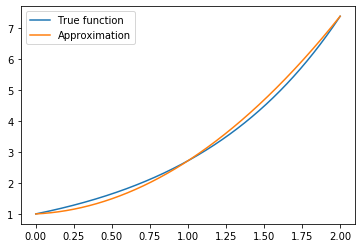

In [9]:
fig, ax = plt.subplots()
ax.plot(xx, yy, label = 'True function')
ax.plot(xx, yy_mono, label = 'Approximation')
ax.legend()

Before moving on, it should be noted when the interpolation nodes $\{x_i\}_{i = 1}^m$ are distinct, there is a *unique* polynomial $p_n(x)$ of degree $n$ that interpolates to the data $\{y_i, x_i\}_{i = 1}^m$. 

This is intuitive, given that we solve a system of linear equations with a matrix - the Vandermonde matrix - whose column vectors are linearly independent. 

This property also implies that if $f$ is itself a polynomial of degree $n$, approximating it with a polynomial of degree $n$ will result in the approximant being the function itself, at every point in the domain: $\hat{f}(x) = f(x)$.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'cheb'></a>

### Chebyshev Basis Functions

Recall that in the context of solving systems of linear equations, we saw that the Vandermonde matrix is ill-conditioned for higher orders of $n$. Compare the example from lecture 3.

In [10]:
def vm(m):
    ## define matrix
    x = np.linspace(1,5,m)
    A = np_poly.polyvander(x, m-1)
    ## determine the solution vector
    b = A @ np.ones(m)
    ## solve SLE
    x = np.linalg.solve(A, b)
    
    return x, A

In [11]:
m = 5
x, A = vm(m)
print("For m = {}, x = {}".format(m, x) )
print("For m = {}, the condition number is {}".format(m, np.linalg.cond(A)))

For m = 5, x = [1. 1. 1. 1. 1.]
For m = 5, the condition number is 26169.68797063433


In [12]:
m = 15
x, A = vm(m)
print("For m = {}, x = {}".format(m, x) )
print("For m = {}, the condition number is {}".format(m, np.linalg.cond(A)))

For m = 15, x = [0.94442222 1.25794398 0.51237487 1.43634172 0.92681916 0.73381653
 1.34080974 0.77274174 1.0993391  0.96979552 1.00646588 0.99904084
 1.00009405 0.99999451 1.00000014]
For m = 15, the condition number is 1.9392318794936404e+18


This implies that computing basis coefficients can be hampered by serious rounding errors, in particular for a large number of interpolation nodes and hence a high degree of approximation. 

Therefore, it is not recommended to use monomials as basis functions for function approximation. Instead, we usually rely on basis functions that are constructed using *orthogonal* polynomials, in particular Chebyshev polynomials.

Let $n$ be the degree of approximation. Then for $j = 0, ..., n$, the *Chebyshev polynomials* $T_j(x)$ are defined as  

\begin{equation*}
  T_j(x) = \cos(j \cos^{-1}(x)),
\end{equation*} 

for $x \in [-1,1]$. Note that this definition only works for the interval $[-1,1]$ because this is the domain of the function $\cos^{-1} = \arccos$ (the "arccosine").

Their first derivatives are given by:

\begin{equation*}
  T'_j(x) = -\sin(j \cos^{-1}(x)) \frac{-j}{\sqrt{1-x^2}} = \sin(j \cos^{-1}(x)) \frac{j}{\sqrt{1-x^2}}. 
\end{equation*} 

An alternative way to define the Chebyshev polynomials is the following *recurrence relationship*: 

\begin{equation}
	T_{j+1}(x) = 2x T_j(x) - T_{j-1},
\end{equation}

for $j \ge 1$, with $T_0(x) = 1$ and $T_1(x) = x$. 

Writing down the first few Chebyshev polynomials, we can see that the polynomial $T_n(x)$ has degree $n$ and if $n$ is even (odd) then $T_n(x)$ involves only even (odd) powers of $x$. 

For example,

\begin{align}
T_2(x) &= 2x^2 - 1 \\
T_3(x) &= 4x^3 - 3x \\
T_4(x) &= 8x^4 - 8x^2 + 1 \\
T_5(x) &= 16x^5 - 20x^3 + 5x 
\end{align}

Note that when working with the Chebyshev polynomials numerically, we use the recursive formula, which is computationally more efficient than the direct definition, in particular for higher values of $n$ and $m$. 

We will see an implementation in Python below.

A (univariate) polynomial $p_n(x)$ that is *represented by a Chebyshev polynomial basis* rather than a power series (monomial) basis is also referred to as a *Chebyshev series*:

\begin{equation}
    p_n(x) = \sum_{j = 0}^n a_j T_j(x)
\end{equation}

This is a polynomial of degree $n$. For example, for $n = 2$, we can write it as a power series:

\begin{equation}
\begin{split}
    p_2(x) &= a_0 T_0(x) + a_1 T_1(x) + a_2 T_2(x) = a_0 + a_1 x + a_2 (2x^2 - 1) \\
           &= (a_0 - a_2) + a_1 x + (2a_2) x^2
\end{split}
\end{equation}

The family of Chebyshev polynomials $\{ T_j(x) \}$ is (mutually) *orthogonal*, which implies that

\begin{equation}
    \int_{-1}^{1} w(x) T_i(x) T_j(x) = 0 \quad \text{for}\ i \neq j 
\end{equation}

with the *weighting function* $w$ given by $w(x) = (1 - x^2)^{-1/2}$.

Why is this a useful property in the context of function approximation? Without going into too much technical detail, we can get some intuition by plotting the Chebyshev polynomials and comparing them to the monomials, here between 0 and 1 (see below). 

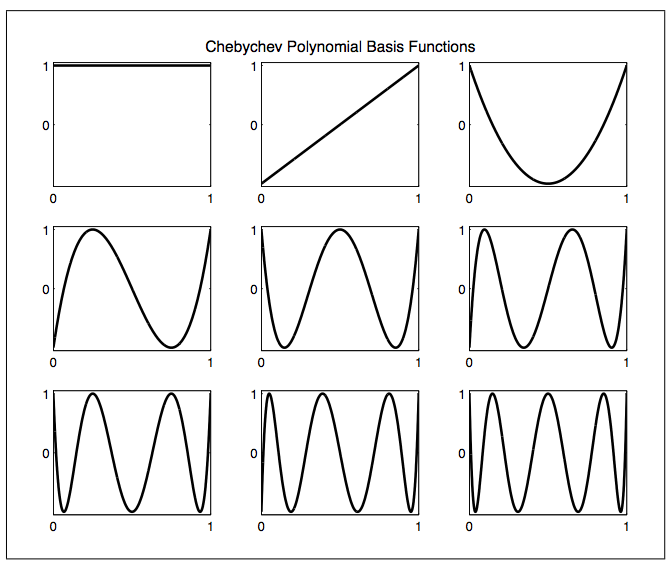

In [13]:
display.Image('cheb.png')

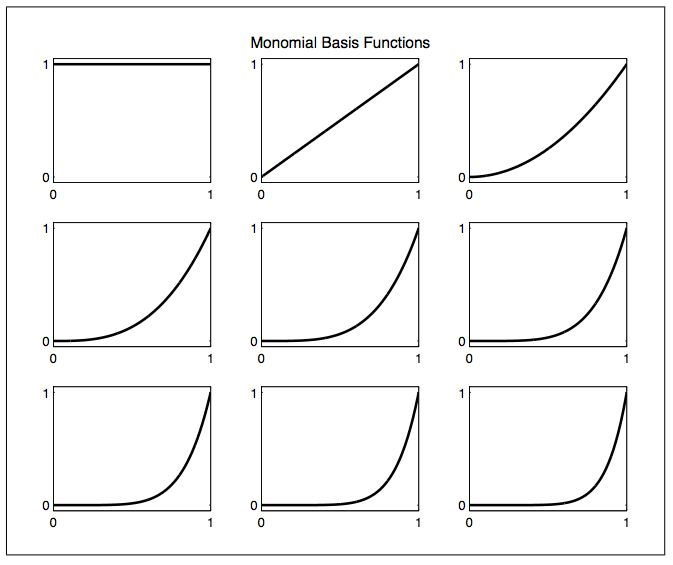

In [14]:
display.Image('mono.png')

Note that the graphs for the Chebyshev polynomials are somewhat distinct, while the ones for the monomials are very similar to each other. 

Intuitively, when we can barely see a difference between two functions graphically, it is likely that the computer will have difficulty discerning the difference numerically, which contributes to the Vandermonde matrix being ill-conditioned. 

Put differently, for a given $x$ value, the monomials cover only a relatively small range of possible function values. In the picture below, for $x = 0.6$, the range of approximately 0 to 0.4.

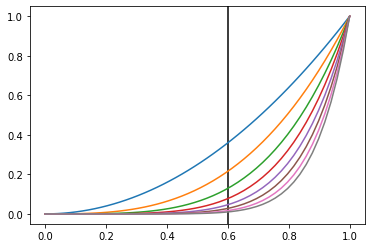

In [61]:
fig, ax = plt.subplots()
x = np.linspace(0, 1, 50)
ax.axvline(0.6, color = 'k')
for i in range(2, 10):
    ax.plot(x, x**i)
    

In contrast, as seen below, the family of Chebyshev polynomials provides a good "coverage" of the function values between $[-1, 1]$. Thus, they are more flexible to approximate arbitrary functions as a weighted sum of these function values.  

Hence, the shape of a polynomial is usually better characterized by the coefficients when it is written in a Chebyshev series than by the corresponding coefficients when written as a power series. 

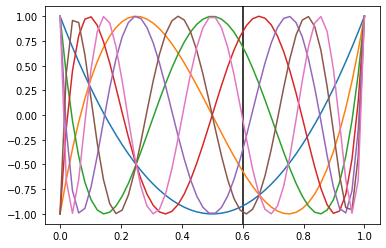

In [60]:
fig, ax = plt.subplots()
x = np.linspace(0, 1, 50)
ax.axvline(0.6, color = 'k')

T = np_cheb.chebvander(2* x - 1, 9)
for i in range(2, 9):
    ax.plot(x, T[:, i])

We can also illustrate this by comparing the conditioning numbers for the Vandermonde and the Chebyshev interpolation matrix for a grid between -1 and 1. 

The latter can be computed by the Numpy function **polynomial.chebyshev.chebvander**. Note that this matrix is sometimes called a *Pseudo-Vandermonde* matrix.

Again, we import the subpackage **polynomial.chebyshev** using an alias (**np_cheb**).

In [15]:
m = 15
x = np.linspace(-1,1,m)
V = np_poly.polyvander(x, m-1)
print( np.linalg.cond(V) )

1104808.5293600995


In [16]:
import numpy.polynomial.chebyshev as np_cheb 

x = np.linspace(-1,1,m)
V = np_cheb.chebvander(x, m-1)
print( np.linalg.cond(V) )

225.73172355048413


We can see that the Vandermonde matrix has a distinctly higher conditioning number than the Pseudo-Vandermonde matrix. As we will discuss in the next section, however, we can still decrease this number considerably. 

Finally, we can run our simple example above, this time using a Chebyshev rather than a monomial basis. In this case, for a low degree of approximation, both choices give equivalent results.  

In [17]:
m = 3
## construct grid
g_min, g_max = 0, 2
xx = np.linspace(g_min, g_max, 100)
yy = fun(xx)
## fit and approximate
a_cheb = np_cheb.chebfit(x_grid, y_grid, m-1)
yy_cheb = np_cheb.chebval(xx, a_cheb)

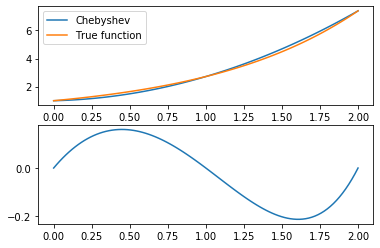

In [18]:
fig, ax = plt.subplots(2, 1)
# ax[0].plot(xx, yy_mono, label = 'Monomial')
ax[0].plot(xx, yy_cheb, label = 'Chebyshev')
ax[0].plot(xx, yy, label = 'True function')
ax[0].legend()
# ax[1].plot(xx, yy - yy_mono)
ax[1].plot(xx, yy - yy_cheb)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'grid'></a>

### Constructing a Grid

Many approximation problems outside of data analysis (where the data points/observations are given by the "real world") allow the modeler to choose the interpolation grid $x_1, x_2,..., x_m$. In the simple example above, we used three equally spaced points between 0 and 2 (i.e. 0,1,2). 

The two features that characterize such a grid are the number of grid points and their spacing. Both have an impact on the quality of the approximation. 

For the number of grid points, this is intuitive: the more data you have, the more information about the function is available. 

However, note that at least in the case of interpolation, the number of basis functions and coefficients increases with the number of grid points, and hence more points mean a larger system of linear equations to solve. 

Why the spacing of grid points matters is less obvious.  

#### Error in Polynomial Interpolation

Let $p_n(x)$ be a polynomial of degree $n$ interpolating to the data $\{x_i, y_i\}_{i = 1}^{m}$, with $m = n + 1$. 

Define $\omega_{n+1}(x) = (x - x_1) (x - x_2) \cdot ... \cdot (x - x_{n+1}) $ and suppose that $x, x_i \in [g_{min}, g_{max}]$.


It can be shown that
\begin{equation}
    \max_{x \in [g_{min}, g_{max}]} \left|\ f(x) - p_n(x)\ \right| \le \max_{x \in [g_{min}, g_{max}]} \left|\ \omega_{n+1}(x)\right| \frac{\max_{z \in [g_{min}, g_{max}]} \left|\ f^{(n + 1)} (z)\ \right|}{(n + 1)!}  
\end{equation}

where $f^{(n + 1)}$ is the $(n + 1)$st derivative of $f$. 

The left-hand side of this expression is the *interpolation error* when approximating $f$ with a polynomial. Hence, the right-hand side provides an *upper bound* on this error. 

Note that if $x = x_i$, we have $\omega_{n+1}(x) = 0$ and hence the interpolation error is zero, which is intuitive. The same is true when the function $f$ is a polynomial of degree $n$, since then $f^{(n + 1)} = 0$. 

We are interested in keeping the interpolation error as small as possible. Note that among the two terms on the right hand side, the term

\begin{equation}
     \frac{\max_{z \in [g_{min}, g_{max}]} \left|\ f^{(n + 1)} (z)\ \right|}{(n + 1)!}  
\end{equation}

is determined by the function to approximate, and hence we cannot do anything to minimize it.

However, the term

\begin{equation}
    \max_{x \in [g_{min}, g_{max}]} \left|\ \omega_{n+1}(x)\ \right|  = \max_{x \in [g_{min}, g_{max}]} \left|\ (x - x_1) (x - x_2) \cdot ... \cdot (x - x_{n+1})\ \right| 
\end{equation}

does not depend on the function, but instead depends on our choice of the grid points $x_1, x_2, ..., x_n$. It turns out that the so-called *Chebyshev nodes* are a good choice to keep this term small.  

#### Chebyshev Nodes

Let $m$ be the number of grid points, indexed by $i$. The Chebyshev nodes between $-1$ and $1$ are given by

\begin{equation}
	z_i = \cos\left(- \frac{(2i - 1)\pi}{2m}\right), \quad i = 1, ..., m
\end{equation}

The following function implements this expression in Python.

In [19]:
def chebnodes(m):
    """ 
    Computes m Chebyshev nodes between -1 and 1.
    """
    i = np.array( range(1, m+1) )
    return -np.cos(0.5 * np.pi * (2 * i - 1) / m)

It can be shown that the Chebyshev nodes are the roots of the Chebyshev polynomial $T_m(x)$. For example, let $m = 2$. Recall that $T_2(x) = 2x^2 - 1$, which has roots at $\sqrt{0.5}$ and $-\sqrt{0.5}$. Computing the Chebyshev notes for $ m = 2$ gives:

In [20]:
chebnodes(2)

array([-0.70710678,  0.70710678])

Plotting the Chebyshev nodes between -1 and 1 shows that they are not equally spaced, but more "bunched up" towards the end points of this interval. 

Note also that these end points are *not* included in the Chebyshev nodes.  

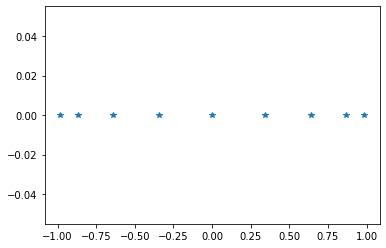

In [21]:
fig, ax = plt.subplots()
ax.plot(chebnodes(9), np.zeros(9), '*')

The following piece of code illustrates the difference between Chebyshev nodes and equally spaced grid points when evaluating the function $ \omega_{n+1}(x) $. 

For five grid points, the maximum value of $\left|\ \omega_{n+1}(x)\ \right|$  (which is what matters for the error bound) is cut by more than half when using Chebyshev nodes. It is easy to check that this difference is even higher when increasing the number of grid points.

In [22]:
def eval_omega(x, nodes):
    '''
    Evaluates the function omega for a given x 
    '''
    return np.prod([(x - node) for node in nodes], axis = 0)

In [23]:
## evaluate omega at equally spaced grid points and plot
n = 5
nodes_es = np.linspace(-1, 1, n+1)

## evaluate omega at Chebyshev nodes and plot
nodes_cheb = chebnodes(n+1)

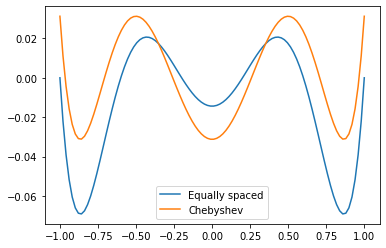

In [24]:
x = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, eval_omega(x, nodes_es), label = 'Equally spaced')
ax.plot(x, eval_omega(x, nodes_cheb), label = 'Chebyshev')
ax.legend()

This result can also be formalized: for a continuously differentiable function $f$, the interpolation error when approximating it with a polynomial of order $n$ on $n + 1$ Chebyshev nodes on the interval $[g_{min}, g_{max}]$ is bounded by:

\begin{equation}
    \max_{x \in [g_{min}, g_{max}]} \left|\ f(x) - p_n(x)\ \right| \le \frac{6}{n} (g_{max} - g_{min}) [\log(n) / \pi + 1] \max_{z \in [g_{min}, g_{max}]} \left|\ f' (z)\ \right| 
\end{equation}

Importantly, this error approaches zero as $n$ rises. Hence, we can achieve a desired degree of accuracy (i.e., make the interpolation error arbitrarily small) by increasing the degree of approximation and hence the number of Chebyshev nodes. 

Note that while we have stated this property in terms of interpolation, using Chebyshev nodes also puts a bound on the approximation error when using least-squares regression.

One could suspect that a crucial disadvantage of using Chebyshev nodes is that they are only defined between -1 and 1. However, with $\{z_i\}$ denoting the $m$ Chebyshev nodes on $[-1,1]$, we can easily define the corresponding Chebyshev nodes on $[g_{min}, g_{max}]$ as:

\begin{equation}
    \tilde{z}_i = g_{min} + \frac{(z_i + 1) ( g_{max} - g_{min})}{2} \quad \text{for}\ i = 1,...,m
\end{equation}

This is implemented in the function **chebgrid** below. The reverse operation is executed by the function **chebconvert**, which is going to be useful below.

In [25]:
def chebgrid(g_min, g_max, m):
    """ 
    Computes num Chebyshev nodes on the interval [g_min, g_max].
    """
    z = chebnodes(m)
    return g_min + (g_max - g_min) * 0.5 * (z + 1) 

def chebconvert(x, g_min, g_max):
    """
    Transforms nodes between [g_min, g_max] to the interval [-1,1].
    """
    return 2. * (x - g_min) / (g_max - g_min) - 1


Two more remarks on Chebyshev nodes:

- It may not only be possible to evaluate the function $f$ at the Chebyshev nodes and hence obtain the data $y_i = f(z_i)$; if this is the case, one should still choose the grid points such that they are denser close to the end points of the interpolation interval.

- *Extrapolation*, i.e. approximating a function *outside* of $[g_{min}, g_{max}]$ using the approximant $\hat{f}$ found by interpolation at the Chebyshev nodes can be disastrous (even more so than when using equally spaced points). In general, extrapolation is never a good idea in the context of function approximation.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'algo'></a>

### Combining Chebyshev Nodes with a Chebyshev Basis

We can summarize the main takeaways from the last two sections:

- Choose Chebyshev nodes (when possible) as the approximation grid, in order to minimize the approximation error

- Use a Chebyshev basis (i.e., Chebyshev polynomials as the basis functions) in order to make the interpolation matrix well-conditioned 

With respect to the last point, it turns out that we can do even better when evaluating *a Chebyshev basis at the Chebyshev nodes*. Formally, we look at

\begin{equation}
\Phi_c =
\left[
\begin{array}{cccc}
    T_0(z_1) & T_1(z_1) & \cdots & T_n(z_1)  \\
    \vdots & \vdots  & \vdots \\
    T_0(z_m) & T_1(z_m) & \cdots & T_n(z_m) &
\end{array}
\right]
\end{equation}

where $m = n + 1$ and $z_i$ are the Chebyshev nodes defined above. 

Also recall that for $j = 0, ..., n$, the Chebyshev polynomials $T_j(x)$ are defined as: 

\begin{equation}
	T_{j+1}(x) = 2x T_j(x) - T_{j-1},
\end{equation}

for $j \ge 1$, with $T_0(x) = 1$ and $T_1(x) = x$. In the following, I will refer to $\Phi_c$ as the "Chebyshev matrix".

The Python function **chebmatrix** implements the Chebyshev matrix, i.e. evaluates the Chebyshev polynomials up to degree $n$ at $m$ Chebyshev nodes, with $m \ge n + 1$. For this, the user needs to provide the arguments **deg** (the degree of approximation) and **'m'**. The function returns an **m-by-deg+1** Numpy array.

In addition, **chebmatrix** also evaluates the Chebyshev polynomials at a scalar or array **'x'**. In this case, the function still returns an **m-by-deg+1**, where **'m'** is the length of the input **x**. 

In [26]:
def chebmatrix(deg, m = None, x = None):
    """
    Computes the m-by-(deg+1) matrix with Chebyshev basis functions of degree deg for m Chebyshev nodes.
    """
    ## check if a second argument is provided
    assert (m != None or np.sum(x) != None), "Please provide the number of grid points or an input vector/scalar x!"
    
    ## check if x values are provided
    if x is None: # default: Chebyshev nodes between -1 and 1 (for interpolation/regression) 
        z = chebnodes(m)
    elif isinstance(x, (list, tuple, np.ndarray)):    # arbitrary vector (for approximation)
        z, m  = x, len(x) 
    else:    # arbitrary scalar (for approximation)
        z, m = x, 1 

    ## define numpy array and fill second column     
    T = np.ones((m, deg + 1))
    T[:,1] = z
    
    ## loop over columns in T; each column corresponds to the Chebyshev basis functions for deg col_idx
    for col_idx in range(1, deg):
        T[:,col_idx+1] = 2 * z * T[:,col_idx] - T[:,col_idx - 1]
    return T

In [27]:
## Examples for different ways to use chebmatrix function
print(chebmatrix(4, 2))
print(chebmatrix(4, x = 0.1))
print(chebmatrix(4, x = np.array([0.1, 0.2])))
# print(chebmatrix(4)) -> only one argument, throws an error!

[[ 1.00000000e+00 -7.07106781e-01  2.22044605e-16  7.07106781e-01
  -1.00000000e+00]
 [ 1.00000000e+00  7.07106781e-01 -2.22044605e-16 -7.07106781e-01
  -1.00000000e+00]]
[[ 1.      0.1    -0.98   -0.296   0.9208]]
[[ 1.      0.1    -0.98   -0.296   0.9208]
 [ 1.      0.2    -0.92   -0.568   0.6928]]


As seen above, NumPy has a function **polynomial.chebyshev.chebvander**, which gives the same matrices. Using **chebmatrix** provides a short-cut, in particular for the default Chebyshev matrix case.

In [28]:
## Use Numpy's polynomial.chebyshev package
print( np_cheb.chebvander(chebnodes(2), 4) )
print( np_cheb.chebvander(np.array([0.1, 0.2]), 4) )

[[ 1.00000000e+00 -7.07106781e-01  2.22044605e-16  7.07106781e-01
  -1.00000000e+00]
 [ 1.00000000e+00  7.07106781e-01 -2.22044605e-16 -7.07106781e-01
  -1.00000000e+00]]
[[ 1.      0.1    -0.98   -0.296   0.9208]
 [ 1.      0.2    -0.92   -0.568   0.6928]]


To see the advantage of using the Chebyshev matrix, compare its condition number to a matrix with a Chebyshev basis evaluated at an equally spaced grid (as above).

In [29]:
m = 15
x = np.linspace(-1,1,m)
Phi = np_cheb.chebvander(x, m-1)
print( np.linalg.cond(Phi) )

225.73172355048413


In [30]:
Phi_c = chebmatrix(m-1, m)
print( np.linalg.cond(Phi_c) )

1.4142135623730974


In the latter case, we get a condition number of $\sqrt{2}$. Importantly, this condition number is not only very near the minimum of 1, but it is also *independent from the degree of approximation and number of Chebyshev nodes*. 

This implies that combining a Chebyshev basis with Chebyshev nodes gives a very well-conditioned interpolation matrix, and hence the interpolation equation $\Phi_c a = y$ can be solved accurately and efficiently. 

More generally, note that the Chebyshev matrix with $m \ge n + 1$ is *orthogonal*: if the Chebyshev polynomials are evaluated at $m$ Chebyshev nodes, the following holds: 

\begin{equation}
\sum _{i=1}^{m}{T_{j}(z_{i})T_{k}(z_{i})}={\begin{cases}0\ \text{if}\ j\neq k\\m\ \text{if}\ j=k=0\\{\frac {m}{2}}\ \text{if}\ j=k\neq 0\end{cases}}
\end{equation}

We can confirm this numerically:

In [31]:
m = 9
T = chebmatrix(5, m)
print(np.sum(T[:,2] * T[:,3]), np.sum(T[:,5] * T[:,4]), np.sum(T[:,0] * T[:,2]))
m = 12
T = chebmatrix(5, m)
print(np.sum(T[:,0] * T[:,0]), np.sum(T[:,5] * T[:,5]), np.sum(T[:,4] * T[:,4]))

-9.992007221626409e-16 2.942091015256665e-15 -8.881784197001252e-16
12.0 5.999999999999998 5.999999999999998


This implies that the $(n+1)\times (n+1)$ matrix $\Phi_c^T \Phi_c$ is a diagonal matrix, with the diagonal elements being equal to either $m/2$ or $m$. Again, we can verify this numerically: 

In [32]:
m = 6
n = 2
Phi_c = chebmatrix(n, m)
print( Phi_c.T @ Phi_c)

[[ 6.00000000e+00 -4.44089210e-16 -3.33066907e-16]
 [-4.44089210e-16  3.00000000e+00 -7.07007168e-16]
 [-3.33066907e-16 -7.07007168e-16  3.00000000e+00]]


Why is this useful? Recall that when approximating a function $f$ using LS regression, we face the problem:

\begin{equation}
    \min_{a_0, ..., a_n} \sum_{i = 1}^m \left[ \sum_{j = 0}^{n} a_j B_j(x_i) - y_i \right]^2.
\end{equation} 

For ease of exposition, denote 
\begin{equation}
    \hat{y}_i = \sum_{j = 0}^{n} a_j B_j(x_i). 
\end{equation}

Taking first-order conditions gives the elements of the gradient:

\begin{equation}
    2 \sum_{i = 1}^m [\hat{y}_i - y_i] B_j(x_i) = 0,\ j=0,..,n
\end{equation}

Rearranging this expression, we get the following system of equation for $j = 0, ..., n$:

\begin{equation}
\begin{split}
    \sum_{i = 1}^m y_i B_j(x_i) &= \sum_{i = 1}^m B_j(x_i) \left[ \sum_{k = 0}^{n} a_k B_k(x_i)  \right] =  \sum_{i = 1}^m \sum_{k = 0}^{n} a_k B_j(x_i)  B_k(x_i)\\
    &= \sum_{k = 0}^{n} a_k \sum_{i = 1}^m  B_j(x_i)  B_k(x_i) 
\end{split}
\end{equation}


Now, suppose we use Chebyshev basis functions, evaluated at the Chebyshev nodes:

\begin{equation}
    \sum_{i = 1}^m y_i T_j(z_i) = \sum_{k = 0}^{n} a_k \sum_{i = 1}^m  T_j(z_i)  T_k(z_i) 
\end{equation}

Recall from above that

\begin{equation}
\sum _{i=1}^{m}{T_{j}(z_{i})T_{k}(z_{i})}={\begin{cases}0\quad \text{if}\ j\neq k\\m\quad \text{if}\ j=k=0\\{\frac {m}{2}}\quad \text{if}\ j=k\neq 0\end{cases}}
\end{equation}

Hence, in the sum over $k$ on the right hand side, all elements are zero except for $k = j$:

\begin{equation}
    \sum_{i = 1}^m y_i T_j(z_i) = a_j \sum_{i = 1}^m  T_j(z_i)  T_j(z_i) 
\end{equation}

This easy to solve for $a_j$:

\begin{equation}
    a_j = \frac{\sum_{i = 1}^m y_i T_j(z_i)}{\sum_{i = 1}^m  T_j(z_i)  T_j(z_i)} = {\begin{cases}\frac{\sum_{i = 1}^m y_i T_j(z_i)}{m} \quad \text{if}\ j=0\\  2\frac{\sum_{i = 1}^m y_i T_j(z_i)}{m}  \quad \text{if}\ j\neq 0\end{cases}}, \quad j = 0, ..., n
\end{equation}

In other words, when using a Chebyshev basis evaluated at the Chebyshev nodes, we can solve the minimization problem underlying least-squares regression in a straightforward fashion.

We can express the same idea using matrix notation. In this case, the regression problem can be written as (verify this!):

\begin{equation}
    \min_{a} \left| \left| \ \Phi a - y\ \right| \right|^2 = (\Phi a - y)^T (\Phi a - y)
\end{equation} 


and recall that the general $\Phi$ has been defined as:

\begin{equation}
\Phi =
\left[
\begin{array}{cccc}
    B_0(x_1) & B_1(x_1) & \cdots & B_n(x_1)  \\
    \vdots & \vdots  & \vdots \\
    B_0(x_m) & B_1(x_m) & \cdots & B_n(x_m) &
\end{array}
\right]
\end{equation}

Solving the minimization problem gives the following system of linear equations:

\begin{equation}
     (\Phi^T \Phi) a = \Phi^T y  
\end{equation}

When using the Chebyshev matrix $\Phi^T$,  $\Phi^T \Phi$ is diagonal, and hence we know that we can solve this system very easily. This last expression is equivalent to the expression for $a_j$ above.

#### Summary: A Chebyshev Approximation Algorithm

Based on the insights above, we can state the following algorithm for approximating a function $f$ for $x \in [g_{min}, g_{max}]$ using a polynomial of degree $n$ and $m \ge n + 1$ grid points:

(i) Compute the $m \ge n + 1$ Chebyshev nodes on $[-1, 1]$: 

\begin{equation}
	z_i = \cos\left(- \frac{(2i - 1)\pi}{2m}\right), \quad i = 1, ..., m
\end{equation}

(ii) Translate the nodes to the $[g_{min}, g_{max}]$ interval:

\begin{equation}
    x_i = g_{min} + \frac{(z_i + 1) (g_{max} - g_{min})}{2}, \quad\ i = 1,...,m
\end{equation}

(iii) Evaluate $f$ at the (translated) nodes:

\begin{equation}
    y_i = f(x_i), \quad\ i = 1,...,m
\end{equation}

(iv) Compute the Chebyshev coefficients $a_i$, $ i = 0, ..., n $:
- when $m = n + 1$, solve the system of linear equations 

\begin{equation}
\begin{split}
\left[
\begin{array}{c}
    y_{1}  \\
    \vdots  \\
    y_{m}
\end{array}
\right] =
\left[
\begin{array}{cccc}
    T_0(z_1) & T_1(z_1) & \cdots & T_n(z_1)  \\
    \vdots & \vdots  & \vdots \\
    T_0(z_m) & T_1(z_m) & \cdots & T_n(z_m) &
\end{array}
\right]
\left[
\begin{array}{c}
    a_{0}  \\
    \vdots  \\
    a_{n}
\end{array}
\right] 
= \Phi
\left[
\begin{array}{c}
    a_{0}  \\
    \vdots  \\
    a_{n}
\end{array}
\right] 
\end{split}
\end{equation}

- more generally, when $m \ge n + 1$, solve the system of linear equations

\begin{equation}
     (\Phi^T \Phi) a = \Phi^T y  
\end{equation}

or, equivalently, compute 

\begin{equation}
    a_j = \frac{\sum_{i = 1}^m y_i T_j(z_i)}{\sum_{i = 1}^m  T_j(z_i)  T_j(z_i)} = {\begin{cases}\frac{\sum_{i = 1}^m y_i T_j(z_i)}{m} \quad \text{if}\ j=k=0\\  2\frac{\sum_{i = 1}^m y_i T_j(z_i)}{m}  \quad \text{if}\ j=k\neq 0\end{cases}}, \quad j = 0, ..., n
\end{equation}

(v) Find the approximant $\hat{f}(x)$ by evaluating


\begin{equation}
    \hat{f}(x) = \sum_{j = 0}^{n} a_j T_j\left( 2 \frac{x - g_{min}}{g_{max} - g_{min}} - 1 \right)
\end{equation}


Note that in the last expression, the term in the parenthesis comes from translating a value $x$ in the interval $[g_{min}, g_{max}]$ to a value in the interval $[-1, 1]$, as done by the function **chebconvert** defined above. 


The following function **chebapprox** implements this algorithm: it uses **chebmatrix** to compute the Chebyshev basis functions (by default at the Chebyshev nodes) and then solves the resulting system of linear equations using either interpolation (if the approximation degree corresponds to the length of the data vector **y**) or regression.

In [33]:
def chebapprox(y, deg):
    """
    Function to compute the Chebyshev coefficients using interpolation or regression
    """
    m = len(y)
    T = chebmatrix(deg, m)

    if deg == m-1: # interpolation (default)
        coef = np.linalg.solve(T,y)
    else:
        coef = np.ones(deg + 1)
        for idx_deg in range(deg + 1):
            coef[idx_deg] = sum(y * T[:,idx_deg]) / sum(T[:,idx_deg]**2)
            
    return coef        
            


Again, there is a Numpy function, **np.polynomial.chebyshev.chebfit**, that does the same (but not with the default Chebyshev nodes). We will see its use below. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'funapprox1'></a>

### Examples: Univariate Function Approximation in Python

#### Example 1: Function Approximation for known functions

Below I approximate the function $y = \exp(-\alpha x)$ between 0 and 2 (compare the Matlab example by Miranda and Fackler for a different interval).

In [34]:
def fun(x, alpha = 2):
    """
    Exponential function
    """
    return np.exp(-alpha * x)

In [35]:
## min and max for approximation grid
g_min, g_max = 0, 2
## number of grid points
m = 9
## Chebyshev grid and function values
p_nodes = chebgrid(g_min, g_max, m)
y = fun(p_nodes) 

In [36]:
a1 = chebapprox(y, m-1)            
a2 = np_cheb.chebfit(chebconvert(p_nodes, g_min, g_max), y, m-1)    

print(a1)
print(a2) 

[ 3.08508323e-01 -4.30538578e-01  1.86478067e-01 -5.75824453e-02
  1.37307308e-02 -2.65952214e-03  4.33119221e-04 -6.07958356e-05
  7.41574370e-06]
[ 3.08508323e-01 -4.30538578e-01  1.86478067e-01 -5.75824453e-02
  1.37307308e-02 -2.65952214e-03  4.33119221e-04 -6.07958356e-05
  7.41574370e-06]


In [37]:
## interpolate over dense grid and plot
x = np.linspace(g_min, g_max, 1001)
y_approx1 = chebmatrix(m-1, x = chebconvert(x, g_min, g_max)) @ a1
y_approx2 = np_cheb.chebval(chebconvert(x, g_min, g_max), a2) 

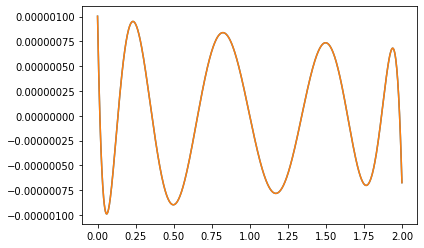

In [38]:
## plot approximation errors
fig, ax = plt.subplots()
ax.plot(x, fun(x) - y_approx1)
ax.plot(x, fun(x) - y_approx2)

In [73]:
c = [0.6, 0.8]
eta = 1.6
e = -1/eta

g_min, g_max = 0.1, 1.5
m = 19
Q2 = chebgrid(g_min, g_max, m)

Q1 = np.empty(m)
for (ind, q2) in enumerate(Q2):
    x0 = q2
    res = scipy.optimize.root(lambda x: (x + q2)**e + e*((x + q2)**(e-1))*x - c[0]*x, x0, method = 'broyden1')
    Q1[ind] = res.x

In [74]:
q1_e, q2_e = [0.8395676, 0.68879643]

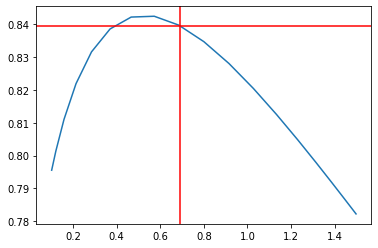

In [75]:
fig, ax = plt.subplots()
ax.plot(Q2, Q1)
ax.axvline(q2_e, color = 'red')
ax.axhline(q1_e, color = 'red')

-----------------------------------------------------------------------------------------------------------------------------
<a id = 'appendix'></a>

## Appendix

#### Example 3: Approximating the Derivative

Suppose you have a function $f$ approximated by a Chebyshev series:

\begin{equation}
   f(x) \approx p_n(x) = \sum_{j = 0}^n a_j T_j(x)
\end{equation}

Then, the derivative of $f$ can be approximated by the derivative of $p_n$, which makes use of the derivatives of the Chebyshev basis functions:

\begin{equation}
   f'(x) \approx p'_n(x) = \sum_{j = 0}^n a_j T'_j(x)
\end{equation}


As an example, consider $n = 3$ and recall the Chebyshev basis functions from above:

\begin{equation}
   p_3(x) = \sum_{j = 0}^3 a_j T_j(x) = a_0 + a_1 x + a_2 (2x^2 - 1) + a_3 (4x^3 - 3x)
\end{equation}

Taking the first derivative w.r.t. $x$ gives:

\begin{equation}
\begin{split}
   \frac{\partial p_3(x)}{\partial x} &= a_1 + 4a_2x + 12a_3 x^2 - 3a_3 \\
   &= (a_1 + 3a_3) + (4 a_2) x + (6a_3) (2x^2 - 1)
\end{split}   
\end{equation}


Using the last rearrangement, we can see that this can be expressed as a Chebyshev series with $n = 2$: 

\begin{equation}
   \frac{\partial p_3(x)}{\partial x} = (a_1 + 3a_3) T_0(x) + (4 a_2) T_1(x) + (6a_3) T_2(x)
\end{equation}

In other words, for a Chebyshev series with parameters $(a_0, a_1, a_2, a_3)$, the first derivative is a Chebyshev series with coefficients $(a_1 + 3a_3, 4 a_2, 6a_3)$. 

An analogous argument can be made for any Chebyshev series of degree $n$: its first derivative is a Chebyshev series of degree $n -1$. 

The Numpy function **chebder** takes the $n+1$ coefficients $(a_0, ..., a_n)$ as an input and computes the $n$ coefficients to be used for the approximation of the first derivative:

In [39]:
print(np_cheb.chebder([1,2,3,4]))

[14. 12. 24.]


In [40]:
def fun(x, alpha = 2):
    """
    Exponential function
    """
    y = np.exp(-alpha * x)

    return y

def fun_d(x, alpha = 2):
    """
    Derivative of the exponential function
    """
    y = -alpha * np.exp(-alpha * x)

    return y

In [41]:
## min and max for approximation grid
g_min, g_max = 0, 2

## number of grid points
m = 9

## Chebyshev grid and function values
x_nodes = chebgrid(g_min, g_max, m)
y = fun(x_nodes) 

In [42]:
## interpolation step
a = chebapprox(y, m - 1)

## Coefficients to approximate derivative
ad = np_cheb.chebder(a)

## interpolate over wide grid
x = np.linspace(g_min, g_max, 1001)
yd_approx = np_cheb.chebval(chebconvert(x, g_min, g_max), ad) 

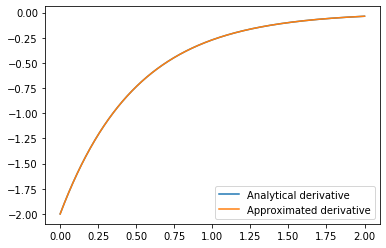

In [43]:
## plot approximation errors
fig, ax = plt.subplots()
ax.plot(x, fun_d(x), label = 'Analytical derivative')
ax.plot(x, yd_approx, label = 'Approximated derivative')
ax.legend()

--------------------------------------------------------------------------------------------------------------------------------